### This notebook shows how to use different alignment algorithms to align two samples.

Install hacca library

In [7]:
# use pip to install hacca
%pip install ..

Defaulting to user installation because normal site-packages is not writeable
Processing c:\users\xiaoyuz\hacca
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for hacca: filename=hacca-0.0.5-py3-none-any.whl size=17104 sha256=2009d3bad2dde25e92f60ac0ce8d32658efebf49e8c4b48db1c14a49f25e31a1
  Stored in directory: C:\Users\xiaoyuz\AppData\Local\Temp\pip-ephem-wheel-cache-akzun983\wheels\d1\ed\cc\4379e64a60e423ecdd87d80467bc6afa106e9f13f2494b48c2
Successfully built hacca
  Attempting uninstall: hacca
    Found existing installation: hacca 0.0.5
    Uninstalling hacca-0.0.5:
      Successfully uninstalled hacca-0.0.5
Note: you may need to restart the kernel to use updated packages.


Import the necessary libraries

In [8]:
import scanpy as sc
import hacca
from hacca import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

Load dataset. This example shows how to align two samples of `.h5ad` format.
- a_h5ad: sampled from sample A and feature X
- b_prime_h5ad: sampled from sample B and feature Y

And we want to get the alignment result (b_predict) using (a, b_prime) as input.

<img src="../asset/cmparision_notebook_notation.png" width="500">

Note that in this example, sample `A` and `B` are the same, therefore we have `a` equals `b`. So that we can use `a` as `b_truth` to evaluate the alignment performance of `b_predict`.

In [9]:
#### dir name
cwd=".."
data_path = os.path.join(cwd, 'data')
work_dir = os.path.join(cwd, 'work_test')
if not os.path.exists(work_dir):
    os.makedirs(work_dir)

a_h5ad = sc.read_h5ad(os.path.join(data_path, "A1.h5ad"))
b_prime_h5ad = sc.read_h5ad(os.path.join(data_path,"A2.h5ad"))

The `spatial` column saves the raw location information of each cell in the original dataset before scaling and centering. and `clusters` save the cluster ID of each cell.

a AnnData object with n_obs × n_vars = 1000 × 2499
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
b_prime AnnData object with n_obs × n_vars = 1000 × 2500
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden', 'spatialX', 'spatialY'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


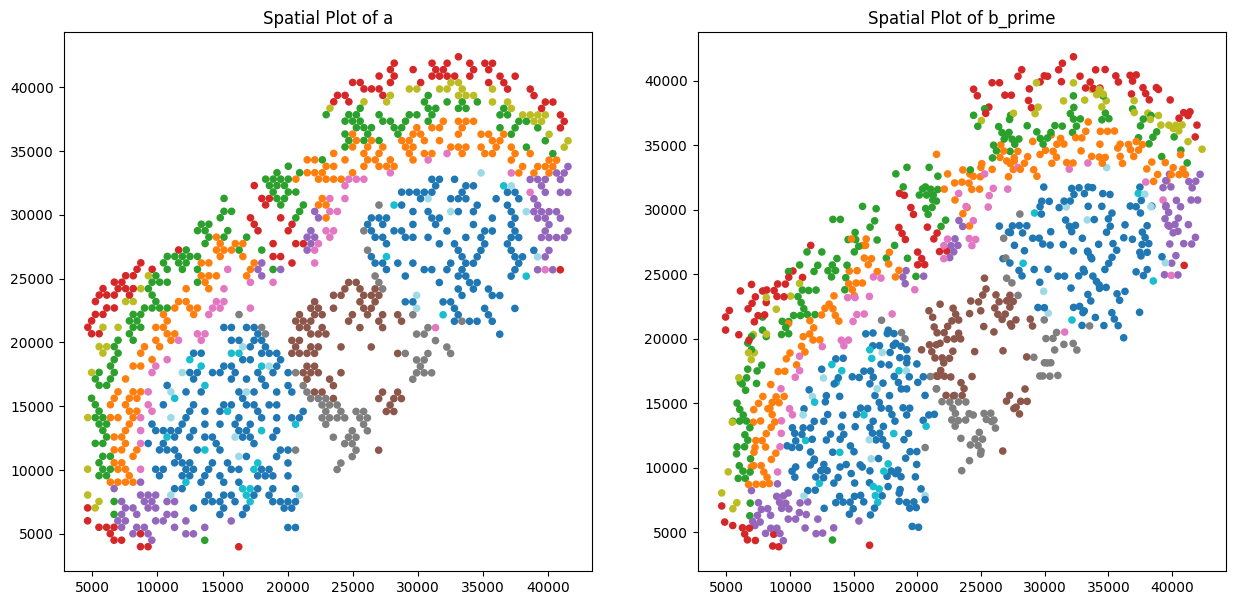

In [10]:
a_h5ad.obs["leiden"] = a_h5ad.obs["clusters"]
b_prime_h5ad.obs["leiden"] = b_prime_h5ad.obs["clusters"]
print("a",a_h5ad)
print("b_prime",b_prime_h5ad)
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].scatter(a_h5ad.obsm["spatial"][:,0], a_h5ad.obsm["spatial"][:,1], c=a_h5ad.obs['leiden'].astype(int), cmap='tab20', s=20, alpha=1,)
axs[0].set_title('Spatial Plot of a')
axs[1].scatter(b_prime_h5ad.obsm["spatial"][:,0], b_prime_h5ad.obsm["spatial"][:,1], c=b_prime_h5ad.obs['leiden'].astype(int), cmap='tab20', s=20, alpha=1)
axs[1].set_title('Spatial Plot of b_prime')
plt.show()

Scale and center the location information of each cell in the original dataset. This step is optional.

In [11]:
b_prime_spatial = pd.DataFrame(b_prime_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(b_prime_spatial)
b_prime_spatial = pd.DataFrame(scaledata, columns=b_prime_spatial.columns).to_numpy()
a_spatial = pd.DataFrame(a_h5ad.obsm['spatial'])
scaledata = hacca.center_and_scale(a_spatial)
a_spatial = pd.DataFrame(scaledata, columns=a_spatial.columns).to_numpy()

Create a `hacca.Data` object from original `.h5ad` files. A `hacca.Data` object is a triple of `(X, D, Label)` where:
- X: the feature matrix of the dataset
- D: the location information of each cell in the dataset
- Label: the cluster information of each cell in the dataset

In [12]:
a = Data(X=a_h5ad.X.toarray(), D = a_spatial, Label=a_h5ad.obs['leiden'].to_numpy())
b_prime = Data(X=b_prime_h5ad.X.toarray(), D = b_prime_spatial, Label=b_prime_h5ad.obs['leiden'].to_numpy())
b_truth = a # use a as the ground truth to evaluate b_predict

hacca packages provides the following alignment algorithms:
- manual_gross_alignment: rough alignment by manually providing three pairs of corresponding points
- further_alignment: further alignment by minimizing the distance between the corresponding points
- icp_2d_alignment: Iterative Closest Point (ICP) algorithm for 2D alignment using `data.D` as input
- icp_3d_alignment: Iterative Closest Point (ICP) algorithm for 3D alignment using `data.D` plus an additional dimension as the 3rd dimension. The additional dimension is calculated from `data.X`.
- fgw_2d_alignment: Fast Global Wasserstein (FGW) algorithm for 2D alignment using `data.D` as input
- fgw_3d_alignment: Fast Global Wasserstein (FGW) algorithm for 3D alignment using `data.D` plus an additional dimension as the 3rd dimension. The additional dimension is calculated from `data.X`.

Alignment pipeline 1: manual_gross_alignment | further_alignment | icp_3d_alignment | direct_alignment

C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\hacca\alignment.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_.loc[:,'BprimeID'] = values
C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\hacca\alignment.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_.loc[:,'AID'] = values
C:\Users\xiaoyuz\AppData\Local\

anchor_points_pairs 7836


C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


lenth of high_correlated_features_pairs 100
haCCA loss: (np.float32(286.8735), np.float64(0.099), -2.802065821557882e-05)


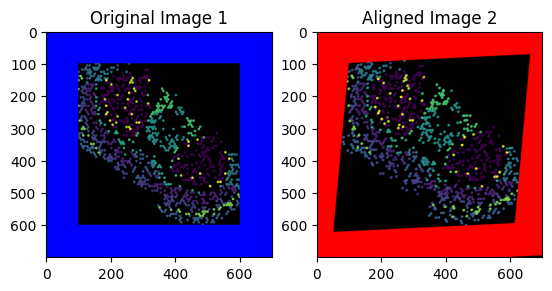

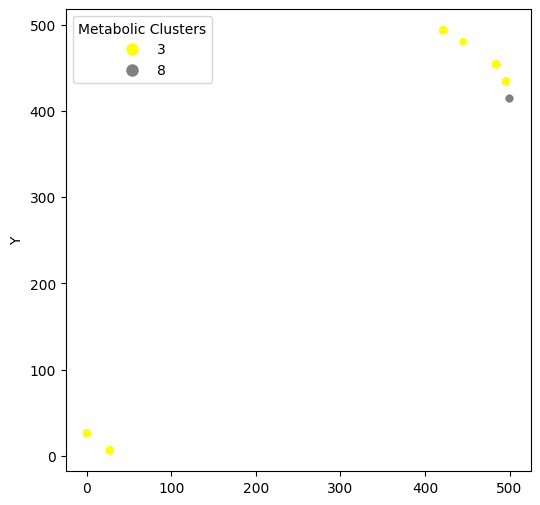

In [13]:
haCCA_work_dir = os.path.join(work_dir, 'haCCA')
if not os.path.exists(haCCA_work_dir):
    os.makedirs(haCCA_work_dir)
_b_prime = hacca.manual_gross_alignment(a, b_prime, work_dir=haCCA_work_dir)
_b_prime = hacca.further_alignment(a, _b_prime)
_a, _b_prime = hacca.icp_2d_with_feature_alignment(a, _b_prime)
b_preidct = hacca.direct_alignment(_a, _b_prime, work_dir=haCCA_work_dir)
haCCA = hacca.loss(b_preidct, b_truth)
print(f"haCCA loss: {haCCA}")
hacca.plot_b_predict(b_preidct,haCCA_work_dir)

Alignment pipeline 2: icp_3d_alignment | direct_alignment

anchor_points_pairs 4145


C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


lenth of high_correlated_features_pairs 100
ICP 3D: loss: (np.float32(294.6307), np.float64(0.099), 0.0), pairwise accuracy: 0.25345628661707975


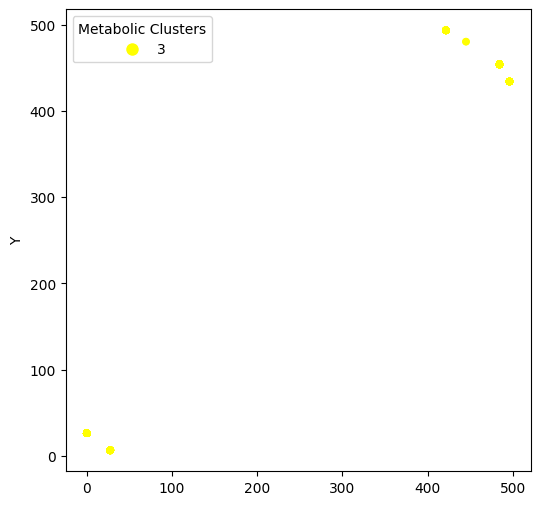

In [13]:
icp_3d_work_dir = os.path.join(work_dir, 'icp_3d')
if not os.path.exists(icp_3d_work_dir):
    os.makedirs(icp_3d_work_dir)
_a, _b_prime = hacca.icp_2d_with_feature_alignment(a, b_prime, icp_3d_work_dir)
pi = hacca.direct_alignment_metric(_a, _b_prime)
b_predict = hacca.direct_alignment(_a, _b_prime, work_dir=icp_3d_work_dir)
hacca.plot_b_predict(b_predict, icp_3d_work_dir)
icp_3d_loss = hacca.loss(b_predict, b_truth)
pairwise_accuracy = hacca.pairwise_alignment_accuracy(_a, _b_prime, pi)
print(f"ICP 3D: loss: {icp_3d_loss}, pairwise accuracy: {pairwise_accuracy}")

Alignment pipeline 3: fgw_3d_alignment | direct_alignment

anchor_points_pairs 4145


C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


lenth of high_correlated_features_pairs 100
FGW 3D: loss: (np.float32(277.65924), np.float64(0.052), 0.04539052003351626)


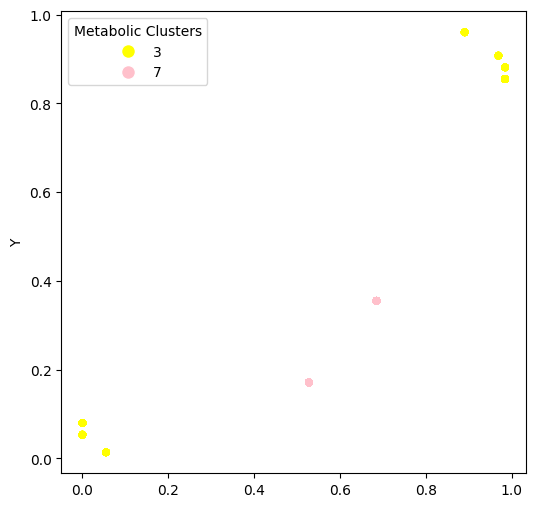

In [14]:
fgw_3d_work_dir = os.path.join(work_dir, 'fgw_3d')
if not os.path.exists(fgw_3d_work_dir):
        os.makedirs(fgw_3d_work_dir)
_a, _b_prime = hacca.fgw_3d_alignment(a, b_prime, fgw_3d_work_dir, alpha=0.8)
b_predict = hacca.direct_alignment(_a, _b_prime, work_dir=fgw_3d_work_dir)
hacca.plot_b_predict(b_predict, fgw_3d_work_dir)
fgw_3d_loss = hacca.loss(b_predict, b_truth)
print(f"FGW 3D: loss: {fgw_3d_loss}")

Alignment pipeline 4: fgw_2d_alignment | direct_alignment

C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\hacca\alignment.py:531: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


FGW 2D: loss: (np.float32(55.991516), np.float64(0.883), 0.8192961476264753)


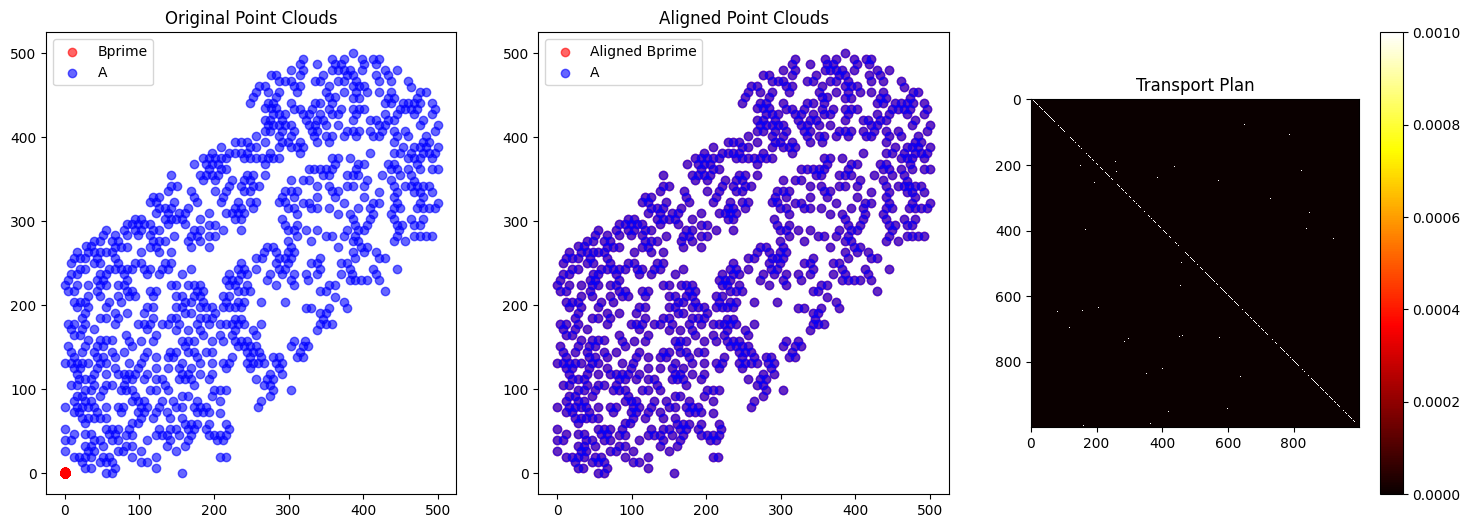

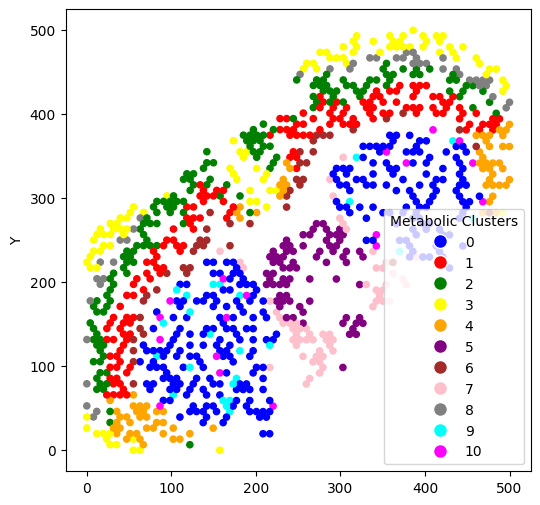

In [10]:
fgw_2d_work_dir = os.path.join(work_dir, 'fgw_2d')
if not os.path.exists(fgw_2d_work_dir):
        os.makedirs(fgw_2d_work_dir)
_b_prime = hacca.fgw_2d_alignment(a, b_prime, fgw_2d_work_dir)
b_predict = hacca.direct_alignment(a, _b_prime, work_dir=fgw_2d_work_dir)
hacca.plot_b_predict(b_predict, fgw_2d_work_dir)
fgw_2d_loss = hacca.loss(b_predict, b_truth)
print(f"FGW 2D: loss: {fgw_2d_loss}")

Alignment pipeline 5: icp_2d_alignment | direct_alignment

Converged after 22 iterations.


C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\hacca\alignment.py:531: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


ICP 2D: loss: (np.float32(65.96968), np.float64(0.796), 0.7034768467481651)


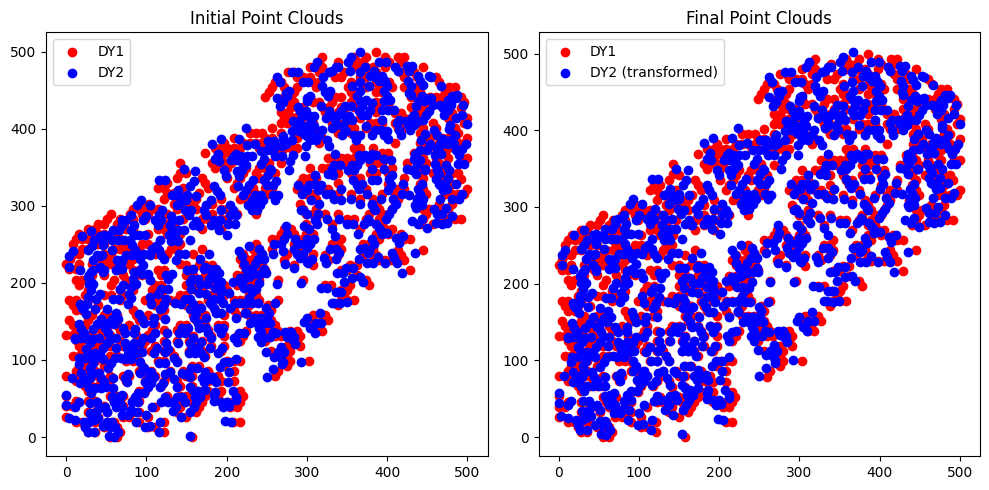

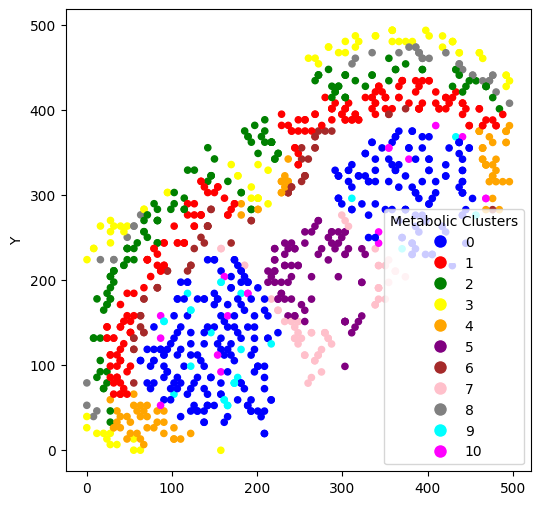

In [11]:
icp_2d_work_dir = os.path.join(work_dir, 'icp_2d')
if not os.path.exists(icp_2d_work_dir):
    os.makedirs(icp_2d_work_dir)

_b_prime = hacca.icp_2d_alignment(a, b_prime, icp_2d_work_dir)
b_predict = hacca.direct_alignment(a, _b_prime, work_dir=icp_2d_work_dir)
hacca.plot_b_predict(b_predict, icp_2d_work_dir)
icp_2d_loss = hacca.loss(b_predict, b_truth)
print(f"ICP 2D: loss: {icp_2d_loss}")

Alignment pipeline 6: direct_alignment

C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\hacca\alignment.py:531: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Direct alignment w/ center and scale: loss: (np.float32(70.601875), np.float64(0.761), 0.6569729156717481)


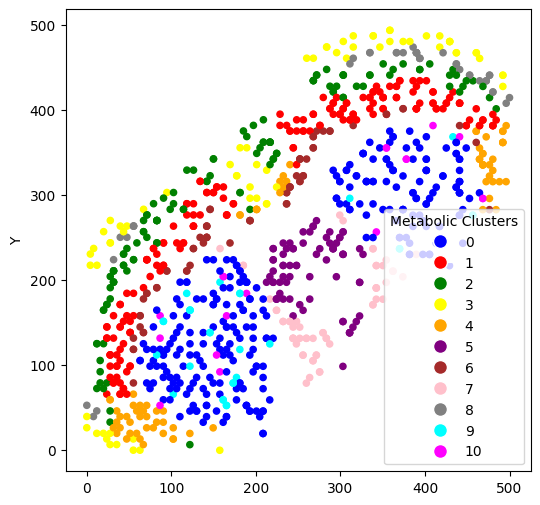

In [12]:
direct_alignment_work_dir = os.path.join(work_dir, 'direct_alignment')
if not os.path.exists(direct_alignment_work_dir):
    os.makedirs(direct_alignment_work_dir)
    
b_predict = hacca.direct_alignment(a, b_prime, direct_alignment_work_dir)
hacca.plot_b_predict(b_predict, direct_alignment_work_dir)
direct_alignment_loss = hacca.loss(b_predict, b_truth)
print(f"Direct alignment w/ center and scale: loss: {direct_alignment_loss}")

Alignment pipeline 7: manual_gross_alignment | direct_alignment

C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\hacca\alignment.py:531: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


manual_alignment: loss: (np.float32(45.07514), np.float64(0.923), 0.8715232098610018)


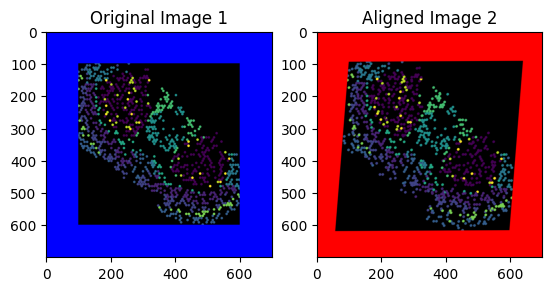

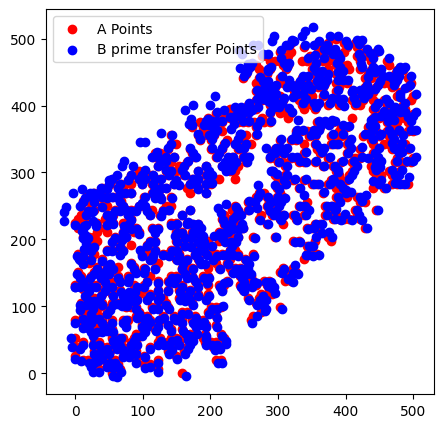

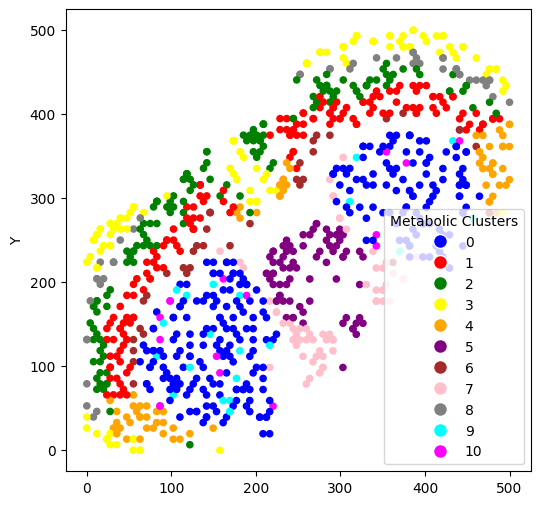

In [13]:
manual_alignment_work_dir = os.path.join(work_dir, 'manual alignment')
if not os.path.exists(manual_alignment_work_dir):
    os.makedirs(manual_alignment_work_dir)
_b_prime = hacca.manual_gross_alignment(a, b_prime, work_dir=manual_alignment_work_dir)
b_preidct = hacca.direct_alignment(a, _b_prime, work_dir=manual_alignment_work_dir)
manual_alignment = hacca.loss(b_preidct, b_truth)
print(f"manual_alignment: loss: {manual_alignment}")
hacca.plot_b_predict(b_preidct,manual_alignment_work_dir)

Alignment pipeline 8: icp_3d_alignment | fgw_3d_alignment | direct_alignment

anchor_points_pairs 6958


C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


lenth of high_correlated_features_pairs 100


C:\Users\xiaoyuz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\hacca\alignment.py:531: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Run ICP2D_FGW3D alignment: loss: (np.float32(55.991516), np.float64(0.883), 0.8192961476264753)


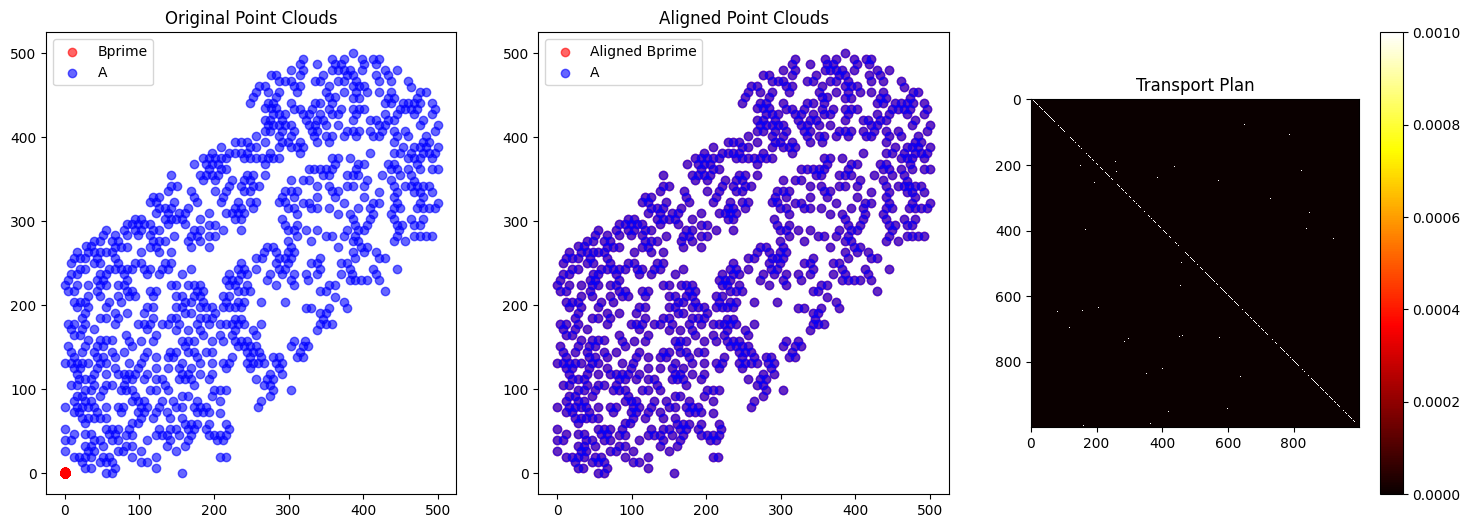

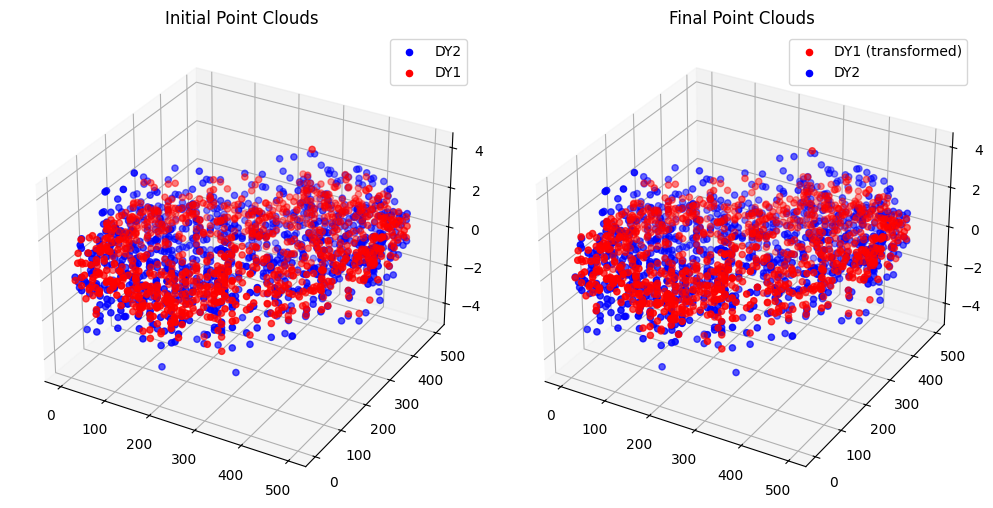

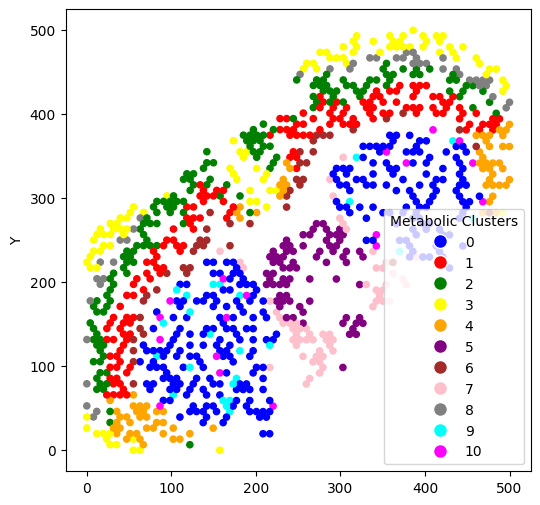

In [14]:
ICP2D_FGW3D_alignment_work_dir = os.path.join(work_dir, 'ICP2D_FGW3D')
if not os.path.exists(ICP2D_FGW3D_alignment_work_dir):
    os.makedirs(ICP2D_FGW3D_alignment_work_dir)
    
_b_prime = hacca.fgw_2d_alignment(a, b_prime, ICP2D_FGW3D_alignment_work_dir)
_a, _b_prime = hacca.icp_3d_alignment(a, _b_prime, ICP2D_FGW3D_alignment_work_dir)
b_predict = hacca.direct_alignment(_a, _b_prime, ICP2D_FGW3D_alignment_work_dir)
hacca.plot_b_predict(b_predict, ICP2D_FGW3D_alignment_work_dir)
ICD2D_FGW3D_alignment_loss = hacca.loss(b_predict, b_truth)
print(f"Run ICP2D_FGW3D alignment: loss: {ICD2D_FGW3D_alignment_loss}")

Let's compare the performance of these alignment algorithms (alignment pieplines 1-8)

In [15]:
print(f"haCCA: loss: {haCCA}")
print(f"FWG2D-ICP3D alignment: loss: {ICD2D_FGW3D_alignment_loss}")
print(f"manual_alignment: loss: {manual_alignment}")
print(f"Direct alignment: loss: {direct_alignment_loss}")
print(f"ICP 2D: loss: {icp_2d_loss}")
print(f"FGW 2D: loss: {fgw_2d_loss}")
print(f"FGW 3D: loss: {fgw_3d_loss}")
print(f"ICP 3D: loss: {icp_3d_loss}")

haCCA: loss: (np.float32(71.903404), np.float64(0.767), 0.6532760843099664)
FWG2D-ICP3D alignment: loss: (np.float32(55.991516), np.float64(0.883), 0.8192961476264753)
manual_alignment: loss: (np.float32(45.07514), np.float64(0.923), 0.8715232098610018)
Direct alignment: loss: (np.float32(70.601875), np.float64(0.761), 0.6569729156717481)
ICP 2D: loss: (np.float32(65.96968), np.float64(0.796), 0.7034768467481651)
FGW 2D: loss: (np.float32(55.991516), np.float64(0.883), 0.8192961476264753)
FGW 3D: loss: (np.float32(69.48714), np.float64(0.732), 0.5752226692421393)
ICP 3D: loss: (np.float32(67.3257), np.float64(0.789), 0.6880357689333824)
